### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster)
from poc.functions import State_Timer
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-11-10T15:18:09.248 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [3]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./Weather.csv', 
                   dtype={"Snowfall":object, "PoorWeather":object, "SNF": object, "TSHDSBRSGF":object},
                   index_col=False, parse_dates=['Date'])

df_i.rename(columns={'Date': 'timestamp'}, inplace=True)

# drastic filtering
df_i = df_i[df_i['STA'] == 10001]

df_i['entity'] = df_i['STA'].astype(str)



# and sort it by timestamp
df_i = df_i[['entity','timestamp','Precip','MaxTemp','MinTemp','MeanTemp']].sort_values(by=['entity','timestamp'])


df_i = df_i.set_index(['entity','timestamp']).dropna()


df_i.head(8)


Precip    MaxTemp    MinTemp   MeanTemp
entity timestamp                                         
10001  1942-07-01  1.016  25.555556  22.222222  23.888889
       1942-07-02      0  28.888889  21.666667  25.555556
       1942-07-03   2.54  26.111111  22.222222  24.444444
       1942-07-04   2.54  26.666667  22.222222  24.444444
       1942-07-05      0  26.666667  21.666667  24.444444
       1942-07-06      0  26.666667  21.666667  24.444444
       1942-07-07      T  28.333333  22.777778  25.555556
       1942-07-08  3.556  26.666667  22.222222  24.444444

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['MaxTemp'], ['MaxTemp'], ['MaxTemp_pred'],[24,25,31])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()


2020-11-10T15:18:17.640 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [24, 25, 31]  lagged_features ['MaxTemp'] Train mode: True
2020-11-10T15:18:17.641 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-10T15:18:17.642 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-10T15:18:17.642 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20201110141817
2020-11-10T15:18:17.643 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-10T15:18:17.643 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-10T15:18:17.643 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-10T15:18:17.644 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
Granulari

,MaxTemp,MinTemp,MeanTemp,MaxTemp_pred
count,1150.000000,1150.000000,1150.000000,1150.000000
mean,30.518357,22.523188,26.526087,30.373166
std,2.500569,1.430077,1.776236,2.608658
min,21.111111,16.111111,20.555556,23.581144
25%,28.472222,21.666667,25.555556,28.413832
50%,31.111111,22.222222,26.666667,31.090970
75%,32.222222,23.333333,27.777778,32.464533
max,35.555556,27.777778,30.555556,35.298166


Text(0, 0.5, 'WWII Weather Data\n(predict max temp from min temp)')

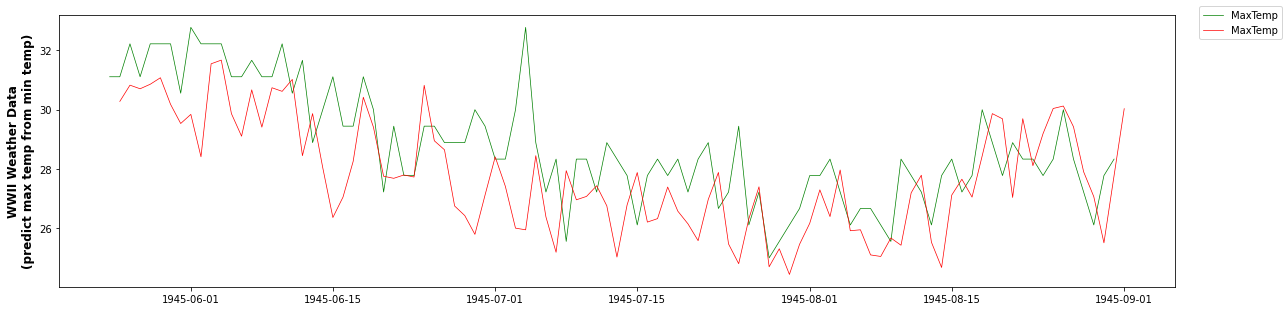

In [5]:
#
df_disp = df_i.tail(100)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,5), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['MaxTemp'],linewidth=0.7,color='green',label='MaxTemp')
ax[cnt,0].plot(df_disp.unstack(level=0).index + pd.DateOffset(hours=24),
               df_disp['MaxTemp_pred'],linewidth=0.7,color='red',label='MaxTemp')

ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")

#df_i[['MaxTemp','__forecast__']].tail(100).plot(figsize=(10,3))
#df_i[['MaxTemp_pred']].tail(48).plot(figsize=(10,3))

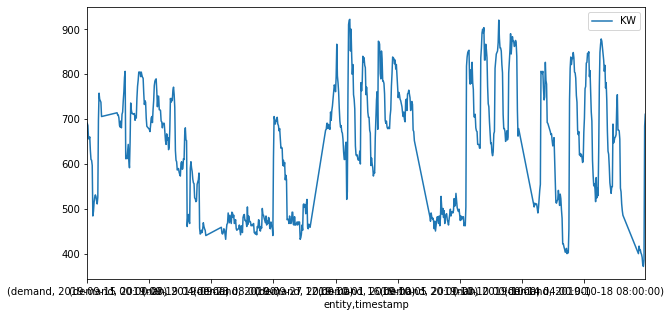

In [6]:
# load data
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
df_input['entity'] = 'demand'
#df_input = df_input.asfreq('H')
df_input.set_index('timestamp', inplace=True)

# fix blue Monday - Monday 9 and 10 am
df_input = df_input[(df_input.index.weekday != 0) | (df_input.index.hour > 10) & (df_input.index.hour < 9)].resample('1H').\
            interpolate().reset_index().set_index(['entity','timestamp'])

df_input[['KW']].head(900).plot(figsize=(10,5))

In [7]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['KW', 'TEMP_AIR'], ['KW'], ['KW_forecast'],[24,48, 168])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_input = spsi.execute(df=df_input)

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2020-11-10T15:18:22.426 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [24, 48, 168]  lagged_features ['KW', 'TEMP_AIR'] Train mode: True
2020-11-10T15:18:22.430 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-10T15:18:22.432 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-10T15:18:22.434 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20201110141822
2020-11-10T15:18:22.435 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-10T15:18:22.435 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-10T15:18:22.437 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-10T15:18:22.437 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
G

,TEMP_AIR,UMIDADE_REL,KW,KW2
count,8280.000000,8280.000000,8280.000000,8280.000000
mean,20.082017,69.152778,578.475841,57.847584
std,4.183426,15.922836,147.592446,14.759245
min,8.300000,15.000000,31.920001,3.192000
25%,17.156000,59.160000,467.040009,46.704001
50%,19.704000,74.000000,546.000000,54.600000
75%,22.600000,81.000000,678.719971,67.871997
max,35.100000,92.000000,944.160000,94.416000


In [8]:
#df_input[['KW','KW_forecast']].tail(26)

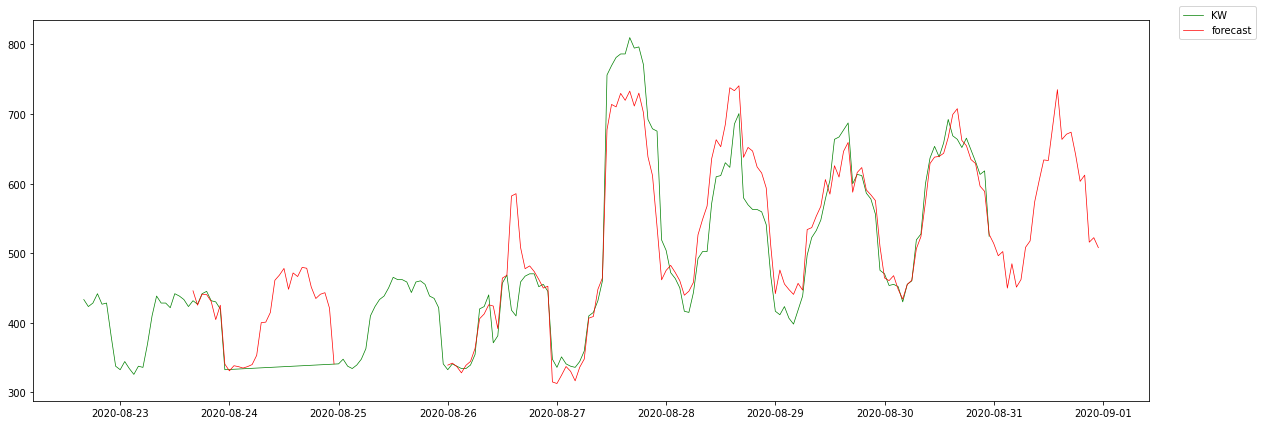

In [9]:
#
df_disp = df_input.tail(200)
df_fore = df_input.tail(200)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,7), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['KW'],linewidth=0.7,color='green',label='KW')
#ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['KW_forecast'],linewidth=0.7,color='blue',label='forecast')
ax[cnt,0].plot(df_disp.unstack(level=0).index + pd.DateOffset(hours=24), df_disp['KW_forecast'],linewidth=0.7,color='red',label='forecast')

ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")


In [61]:
# load data
df_inp = pd.read_csv('AllOfArmstark.csv', parse_dates=['timestamp'], comment='#')
#df_inp.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
#df_inp.set_index(['entity','timestamp'], inplace=True)

df_inp.head(3)

,entity,timestamp,Vx,Vy,Vz,Ap,As,speed
0,04714B6046D5,2020-01-01 00:02:25.928,-0.0439,-0.0137,-1.0029,2.2904,1.036,1.036
1,04714B6046D5,2020-01-01 00:03:25.928,-0.0430,-0.0205,-0.9023,2.2904,1.036,1.036
2,04714B6046D5,2020-01-01 00:04:25.928,0.0039,-0.0371,-1.0596,2.2904,1.036,1.036


In [66]:
#
df_i1 = df_inp[df_inp['entity']=='04714B6046D5']
df_i2 = df_inp[df_inp['entity']=='04714B604101']
df_vx1 = df_i1[['Vx']]
df_sp1 = df_i1[['As']]
df_vx2 = df_i2[['Vx']]
df_sp2 = df_i2[['Ap']]

df_sp2


,Ap
129300,2.3650
129301,2.3650
129302,2.3650
129303,2.3388
129304,2.3388
...,...
258490,2.2722
258491,2.2722
258492,2.2800
258493,2.2800


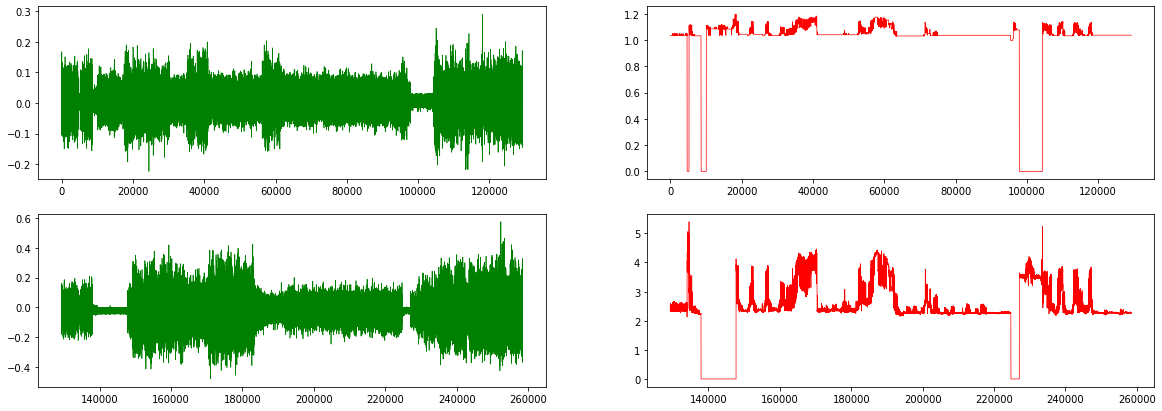

In [68]:
plots = 2
fig, ax = plt.subplots(plots, 2, figsize=(20,7), squeeze=False)
cnt = 0
ax[0,0].plot(df_vx1,linewidth=0.7,color='green',label='Vibration 1')
ax[0,1].plot(df_sp1,linewidth=0.7,color='red',label='Speed 1')
#ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['KW_forecast'],linewidth=0.7,color='blue',label='forecast')
cnt = 1
ax[1,0].plot(df_vx2, linewidth=0.7,color='green',label='Vibration 2')
ax[1,1].plot(df_sp2,linewidth=0.7,color='red',label='Speed 2')

#ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")

In [76]:

df_i1.set_index(['entity','timestamp'], inplace=True)

KeyError: "None of ['entity', 'timestamp'] are in the columns"

In [73]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['Vx', 'As'], ['Vx'], ['Vx_forecast'],[100,200,300])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i1  = spsi.execute(df=df_i1)

EngineLogging.configure_console_logging(logging.INFO)
df_i1.head(3)

2020-11-10T15:51:43.496 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [100, 200, 300]  lagged_features ['Vx', 'As'] Train mode: True
2020-11-10T15:51:43.500 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-10T15:51:43.502 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-10T15:51:43.504 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20201110145143
2020-11-10T15:51:43.505 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-10T15:51:43.508 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-10T15:51:43.509 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-10T15:51:43.510 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
Granu

2020-11-10T15:52:03.432 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.Vx.04714B6046D5
2020-11-10T15:52:03.449 DEBUG iotfunctions.util.log_df_info After adding predictions for target Vx ; df row count: 129000  ; index: { entity , timestamp }  ; columns: { Vx , Vy , Vz , Ap , As , speed , Vx_100 , Vx_200 , Vx_300 , As_100 , As_200 , As_300 , _DayOfWeekCos_ , _DayOfWeekSin_ , _DayOfYearCos_ , _DayOfYearSin_ , Vx_forecast }


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


lags [100, 200, 300]  lagged_features ['Vx', 'As'] Train mode: False
['Vx_100' 'Vx_200' 'Vx_300' 'As_100' 'As_200' 'As_300' '_DayOfWeekCos_'
 '_DayOfWeekSin_' '_DayOfYearCos_' '_DayOfYearSin_']
2020-11-10T15:52:06.117 INFO iotfunctions.base.get_models_for_training predicting target Vx
2020-11-10T15:52:06.118 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.Vx.04714B6046D5 of size 1877685 bytes has been retrieved from filesystem
2020-11-10T15:52:06.180 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.Vx.04714B6046D5",
 "target": "Vx",
 "features": [
  "Vx_100",
  "Vx_200",
  "Vx_300",
  "As_100",
  "As_200",
  "As_300",
  "_DayOfWeekCos_",
  "_DayOfWeekSin_",
  "_DayOfYearCos_",
  "_DayOfYearSin_"
 ],
 "estimator_name": "light_gradient_boosted_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 0.26016165820709325,
 "eval_metric_test": -0.046401015968007

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


2020-11-10T15:52:09.412 DEBUG mmfunctions.anomaly.execute Drop artificial features ['Vx_100' 'Vx_200' 'Vx_300' 'As_100' 'As_200' 'As_300' '_DayOfWeekCos_'
 '_DayOfWeekSin_' '_DayOfYearCos_' '_DayOfYearSin_']


Vx      Vy      Vz      Ap     As  \
entity       timestamp                                                        
04714B6046D5 2020-01-01 01:12:26.172 -0.0449 -0.0596 -0.8887  2.2842  1.036   
             2020-01-01 01:13:26.172 -0.0078 -0.0625 -0.8906  2.2814  1.036   
             2020-01-01 01:14:26.172  0.0205 -0.0293 -1.0547  2.2814  1.036   

                                      speed  Vx_forecast  
entity       timestamp                                    
04714B6046D5 2020-01-01 01:12:26.172  1.036    -0.003405  
             2020-01-01 01:13:26.172  1.036     0.010694  
             2020-01-01 01:14:26.172  1.036    -0.007448

In [53]:
df_in2 = df_i2.copy()
df_in2['entity'] = '04714B6046D5'
df_in2.set_index(['entity','timestamp'], inplace=True)

In [78]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = {'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['Vx', 'As'], ['Vx'], ['Vx_forecast'],[100,200,300])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_in2  = spsi.execute(df=df_in2)

EngineLogging.configure_console_logging(logging.INFO)
df_in2.head(3)

2020-11-10T15:53:10.748 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [100, 200, 300]  lagged_features ['Vx', 'As'] Train mode: True
2020-11-10T15:53:10.750 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-10T15:53:10.750 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-10T15:53:10.750 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20201110145310
2020-11-10T15:53:10.751 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-10T15:53:10.751 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-10T15:53:10.752 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-10T15:53:10.753 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
Granu

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


lags [100, 200, 300]  lagged_features ['Vx', 'As'] Train mode: False
['Vx_100' 'Vx_200' 'Vx_300' 'As_100' 'As_200' 'As_300' '_DayOfWeekCos_'
 '_DayOfWeekSin_' '_DayOfYearCos_' '_DayOfYearSin_']
2020-11-10T15:53:13.258 INFO iotfunctions.base.get_models_for_training predicting target Vx
2020-11-10T15:53:13.259 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.Vx.04714B6046D5 of size 1877685 bytes has been retrieved from filesystem
2020-11-10T15:53:13.279 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.Vx.04714B6046D5",
 "target": "Vx",
 "features": [
  "Vx_100",
  "Vx_200",
  "Vx_300",
  "As_100",
  "As_200",
  "As_300",
  "_DayOfWeekCos_",
  "_DayOfWeekSin_",
  "_DayOfYearCos_",
  "_DayOfYearSin_"
 ],
 "estimator_name": "light_gradient_boosted_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 0.26016165820709325,
 "eval_metric_test": -0.046401015968007

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


2020-11-10T15:53:17.396 DEBUG mmfunctions.anomaly.execute Drop artificial features ['Vx_100' 'Vx_200' 'Vx_300' 'As_100' 'As_200' 'As_300' '_DayOfWeekCos_'
 '_DayOfWeekSin_' '_DayOfYearCos_' '_DayOfYearSin_']


Vx      Vy      Vz      Ap     As  \
entity       timestamp                                                        
04714B6046D5 2020-01-01 16:52:34.469  0.0234 -0.0918 -0.9268  2.3358  1.034   
             2020-01-01 16:53:34.469 -0.0635 -0.0342 -0.9746  2.3358  1.034   
             2020-01-01 16:54:34.469 -0.0645 -0.0332 -0.9482  2.3364  1.034   

                                      speed  Vx_forecast     error  
entity       timestamp                                              
04714B6046D5 2020-01-01 16:52:34.469  1.035     0.011358  0.009867  
             2020-01-01 16:53:34.469  1.035    -0.003784  0.072272  
             2020-01-01 16:54:34.469  1.035     0.000662  0.061839

In [79]:
df_i1.reset_index().set_index('timestamp')[['Vx']]

,Vx
timestamp,
2020-01-01 01:12:26.172,-0.0449
2020-01-01 01:13:26.172,-0.0078
2020-01-01 01:14:26.172,0.0205
2020-01-01 01:15:26.172,-0.0234
2020-01-01 01:16:26.172,0.0049
...,...
2020-01-31 12:09:23.501,0.0293
2020-01-31 12:10:23.501,-0.0879
2020-01-31 12:11:23.501,0.0596


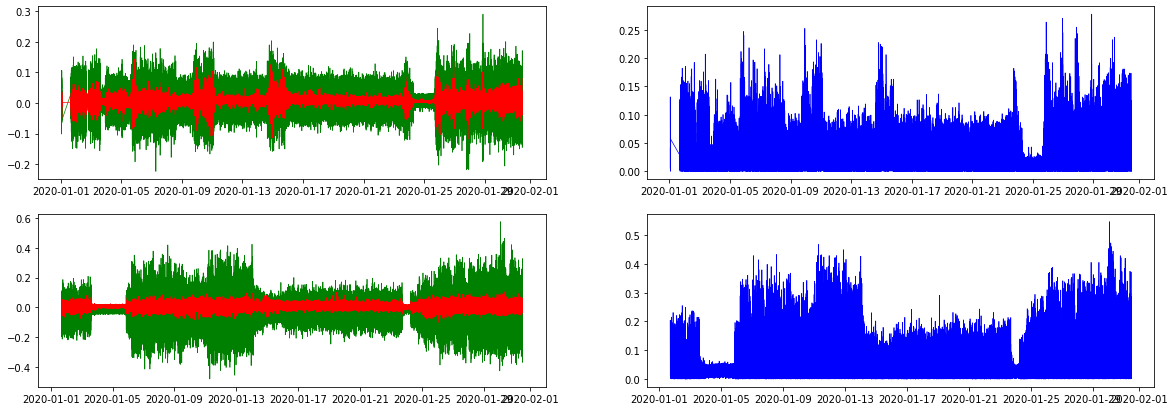

In [80]:
#
#df_inp.reset_index(inplace=True)

#df_ii1 = df_inp[df_inp['entity']=='04714B6046D5']
#df_ii2 = df_inp[df_inp['entity']=='04714B604101']

df_i1['error'] = np.abs(df_i1['Vx'] - df_i1['Vx_forecast'])
df_vxi1 = df_i1.reset_index().set_index('timestamp')[['Vx']]
df_spi1 = df_i1.reset_index().set_index('timestamp')[['Vx_forecast']]
df_er1 = df_i1.reset_index().set_index('timestamp')[['error']]

df_in2['error'] = np.abs(df_in2['Vx'] - df_in2['Vx_forecast'])
df_vxi2 = df_in2.reset_index().set_index('timestamp')[['Vx']]
df_spi2 = df_in2.reset_index().set_index('timestamp')[['Vx_forecast']]
df_er2 = df_in2.reset_index().set_index('timestamp')[['error']]




plots = 2
fig, ax = plt.subplots(plots, 2, figsize=(20,7), squeeze=False)
cnt = 0
ax[0,0].plot(df_vxi1,linewidth=0.7,color='green',label='Vibration 1')
ax[0,0].plot(df_spi1,linewidth=0.7,color='red',zorder=10, label='Vibration forecast 1')
ax[0,1].plot(df_er1, linewidth=0.7,color='blue', label='Error 1')
#ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['KW_forecast'],linewidth=0.7,color='blue',label='forecast')
cnt = 1
ax[1,0].plot(df_vxi2, linewidth=0.7,color='green',label='Vibration 2')
ax[1,0].plot(df_spi2,linewidth=0.7,color='red',zorder=10, label='Vibration forecast 2')
ax[1,1].plot(df_er2, linewidth=0.7,color='blue', label='Error 2')


In [17]:
df_spi1

,Vx_forecast
0,-0.00360184
1,0.00940023
2,0.00480692
3,-0.0139824
4,0.00538997
...,...
129095,0.0226374
129096,-0.00308767
129097,-0.00182447
129098,0.00428083
